# Feature Engineering and Baseline Modeling
<br>

During this phase, we extract features from our audio signals and run baseline model tests using our oversampled dataset as the train and validation inputs. To get the features, as mel-spectrograms, we used NVIDIAs data loading library, "DALI". Using the processing operators provided by DALI we were able to extract the spectrograms at a fraction of the time it would take using "librosa" because the library is accelerated via GPU. DALI produced identical mel-spectrograms in comparison to librosa, giving us an array output size of 251x128 for each of the 304,675 audios. The total spectrograms were split using a stratified K-fold split of 80/20.  

With our X/y, train/test we performed various transformations in order to compress the data to fit our models and perform under limited computing conditions. Principal component analysis (PCA) of .95 was used to reduce the datasets dimensions and MinMaxScaler() with a feature range of 0,1 was used to scale each float making up the unique spectrogram of each individual audio. Once all transformations and scaling was completed we were then able to construct our baseline models. 

### Models:
- Logistic regression
- Two support vector classifiers (SVC) 
    - One utilizing Sklearns library
        - Long training times 
    - One utilizing RAPIDS (cuML) library
        - Accelerated for performance
- XGBoost 

<br>
Each of the models were tuned and fit using GridSearchCV() with 10 folds, allowing us to find the best hyperparameters for each respective model. Using the "best-estimator" method we conducted our predictions with X_test. The only model that did not utilize the GridSearch method was XGBoost, as we used their internal documentation to build it.

A summary of each model can be found at the beginning of its predictions, and our findings are located at the very end of the notebook. 

In [1]:
from sklearnex import patch_sklearn
patch_sklearn()

from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.svm import SVC as skSVC

from cuml.svm import SVC as cumlSVC

from xgboost import XGBClassifier
import xgboost as xgb

import os
import cuml
import pandas as pd
import numpy as np
import subprocess

import matplotlib.pyplot as plt
import matplotlib

%matplotlib inline
matplotlib.rc({"figure.dpi": 300, 'savefig.dpi': 300})
#sns.set_style("ticks")
#sns.set_theme(style="darkgrid")
new_style = {'grid': False}
matplotlib.rc('axes', **new_style)

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


In [2]:
# Load data

train_OS = pd.read_csv('./capstone-project-3/data/train_OS.csv')
train_OS.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 304675 entries, 0 to 304674
Data columns (total 2 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   audio_file  304675 non-null  object
 1   label       304675 non-null  object
dtypes: object(2)
memory usage: 4.6+ MB


In [3]:
# Assigning numerical values and storing in another column

labelencoder = LabelEncoder()
train_OS['label_encoded'] = labelencoder.fit_transform(train_OS['label'])

In [4]:
from nvidia.dali import pipeline_def, Pipeline
import nvidia.dali.fn as fn
import nvidia.dali.types as types
import cupy as cp 

cp.cuda.set_allocator(cp.cuda.MemoryPool(cp.cuda.malloc_managed).malloc) # GPU memory management

In [5]:
audio_files = list(train_OS['audio_file']) # .wav inputs
audio_labels = list(train_OS['label_encoded']) # label inputs

In [9]:
batch_size = 1
n_iter = int(len(audio_files) / batch_size) # One iteration for each audio
n_fft = 2048 
hop_length = 512

# Initiate processing pipeline
pipe = Pipeline(batch_size=batch_size,
                num_threads=15,
                device_id=0,
                enable_memory_stats=True,
                exec_pipelined=False,
                exec_async=False,
                py_num_workers=15)

# Actions to perform with pipeline 
with pipe:
    encoded, _ = fn.readers.file(files=audio_files) # Read .wav
    audio, sr = fn.decoders.audio(encoded, dtype=types.FLOAT) # Decode .wav, get signal and sample rate
    
    # Get signal spectrogram
    spectrogram = fn.spectrogram(audio.gpu(),
                                 nfft=n_fft,
                                 window_length=n_fft,
                                 window_step=hop_length)
    
    # Get mel-power spectrogram features
    mel_spectrogram = fn.mel_filter_bank(spectrogram.gpu(),
                                         sample_rate=16000,
                                         nfilter=128,
                                         freq_high=8000.0,
                                         bytes_per_sample_hint=128512)
    
    # Convert array spectrograms to decibels
    mel_spectrogram_dB = fn.to_decibels(mel_spectrogram,
                                        multiplier=10.0,
                                        cutoff_db=-80,
                                        bytes_per_sample_hint=128512)
    
    # Set outputs and reshape dimensions (1 row per label)
    pipe.set_outputs(fn.reshape(mel_spectrogram_dB, shape=[1, 128*251])) 

pipe.build()

In [10]:
# Iterate over length of number of audios per class to perform pipeline operations

X_spec = []

for i in range(n_iter):
    pipe_out = pipe.run()
    spec = cp.array(pipe_out[0][0])
    X_spec.append(spec)

    percent = i / len(train_OS) * 100
    print("", end=f"\rPercent complete: {round(percent, 2)} %  ")
    
X_v = cp.vstack(X_spec) # VStack arrays to match y shape

Percent complete: 100.0 %  

In [16]:
X = cp.asnumpy(X_v)
X.shape

(304675, 32128)

In [19]:
del X_spec # Uses over 150 GB of RAM

y = np.vstack(audio_labels) # VStack labels for matching X shapes
y.shape

(304675, 1)

In [22]:
np.save('X_specs', X)
np.save('y_labels', y)

In [25]:
# Initiate stratified KFold train/test split 

skf = StratifiedKFold(n_splits=10)
skf.get_n_splits(X, y)

print(skf)

StratifiedKFold(n_splits=10, random_state=None, shuffle=False)


In [26]:
# Splitting X and y -> X_train, y_train, X_test, y_test (80/20)

for train_index, test_index in skf.split(X, y):
    print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

TRAIN: [ 16523  16524  16525 ... 304672 304673 304674] TEST: [    0     1     2 ... 70486 70496 70497]
TRAIN: [     0      1      2 ... 304672 304673 304674] TEST: [ 16523  16524  16525 ... 141142 141143 141146]
TRAIN: [     0      1      2 ... 304672 304673 304674] TEST: [ 33210  33211  33212 ... 159359 159360 159362]
TRAIN: [     0      1      2 ... 304672 304673 304674] TEST: [ 49726  49731  49733 ... 177575 177576 177577]
TRAIN: [     0      1      2 ... 304672 304673 304674] TEST: [ 66228  66229  66230 ... 195792 195793 203978]
TRAIN: [     0      1      2 ... 304672 304673 304674] TEST: [ 82806  82807  82808 ... 214008 214009 222194]
TRAIN: [     0      1      2 ... 304672 304673 304674] TEST: [ 99237  99238  99239 ... 232224 232225 240410]
TRAIN: [     0      1      2 ... 304672 304673 304674] TEST: [115640 115641 115642 ... 250440 250441 266809]
TRAIN: [     0      1      2 ... 304672 304673 304674] TEST: [132178 132179 132180 ... 292421 292422 292423]
TRAIN: [     0      1    

In [28]:
np.save('X_train', X_train)
np.save('y_train', y_train)
np.save('X_test', X_test)
np.save('y_test', y_test)

In [31]:
# Clean and free RAM

del X_v
del X

del mel_spectrogram
del mel_spectrogram_dB

del spectrogram
del pipe
del pipe_out

In [82]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [6]:
# Scale features

scaler = MinMaxScaler(feature_range=(0,1))
scaler.fit(X_train)

MinMaxScaler()

In [10]:
# Apply scale

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
y_train = np.ravel(y_train)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(274208, 32128) (30467, 32128) (274208,) (30467, 1)


In [ ]:
# Reduce dimensionality of features

pca = PCA(.95)
pca.fit(X_train)

In [9]:
# Apply PCA reduction

X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

In [14]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(274208, 742) (30467, 742) (274208,) (30467, 1)


In [15]:
np.save('tX_train.npy', X_train)
np.save('ty_train.npy', y_train)
np.save('tX_test.npy', X_test)
np.save('ty_test.npy', y_train)

In [2]:
X_train = np.load('tX_train.npy')
y_train = np.load('ty_train.npy')
X_test = np.load('tX_test.npy')
y_test = np.load('ty_test.npy')

In [85]:
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(274208, 742) (30467, 742) (274208,) (30467, 1)


In [3]:
# SVC and LOG Gridsearch Pipeline 

logr_params = {
    'penalty': ['l2'],
    'C':[0.001,.009,0.01,.09,1,5,10,25]
}
cumlSVC_params = {
    'C': [10, 100], 
    'gamma': [0.01, 0.001],
    'kernel': ['rbf']
}


models = {
    'LOGR':
    GridSearchCV(LogisticRegression(multi_class='multinomial', max_iter=5000), 
                                    param_grid=logr_params, scoring= 'roc_auc_ovo_weighted', 
                                    verbose=3).fit(X_train, y_train).best_estimator_,
    'cumlSVC':
    GridSearchCV(cumlSVC(cache_size=8000, verbose=3), 
                         param_grid=cumlSVC_params, refit=True, 
                         verbose=3).fit(X_train, y_train).best_estimator_,
}

Fitting 5 folds for each of 8 candidates, totalling 40 fits
[CV 1/5] END ...............C=0.001, penalty=l2;, score=0.540 total time=  12.9s
[CV 2/5] END ...............C=0.001, penalty=l2;, score=0.706 total time=  12.2s
[CV 3/5] END ...............C=0.001, penalty=l2;, score=0.673 total time=  11.5s
[CV 4/5] END ...............C=0.001, penalty=l2;, score=0.743 total time=  11.6s
[CV 5/5] END ...............C=0.001, penalty=l2;, score=0.757 total time=  13.1s
[CV 1/5] END ...............C=0.009, penalty=l2;, score=0.538 total time=  22.0s
[CV 2/5] END ...............C=0.009, penalty=l2;, score=0.707 total time=  22.0s
[CV 3/5] END ...............C=0.009, penalty=l2;, score=0.675 total time=  21.3s
[CV 4/5] END ...............C=0.009, penalty=l2;, score=0.743 total time=  22.9s
[CV 5/5] END ...............C=0.009, penalty=l2;, score=0.758 total time=  26.7s
[CV 1/5] END ................C=0.01, penalty=l2;, score=0.538 total time=  26.0s
[CV 2/5] END ................C=0.01, penalty=l2;,

/home/ubuntu/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 1/5] END ..................C=10, penalty=l2;, score=0.538 total time= 1.9min


/home/ubuntu/anaconda3/envs/rapids-21.06/lib/python3.8/site-packages/daal4py/sklearn/linear_model/logistic_path.py:432: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV 2/5] END ..................C=10, penalty=l2;, score=0.707 total time= 2.0min
[CV 3/5] END ..................C=10, penalty=l2;, score=0.676 total time= 1.6min
[CV 4/5] END ..................C=10, penalty=l2;, score=0.742 total time= 1.0min
[CV 5/5] END ..................C=10, penalty=l2;, score=0.758 total time= 1.8min
[CV 1/5] END ..................C=25, penalty=l2;, score=0.538 total time= 1.5min
[CV 2/5] END ..................C=25, penalty=l2;, score=0.707 total time= 1.0min
[CV 3/5] END ..................C=25, penalty=l2;, score=0.676 total time= 1.4min
[CV 4/5] END ..................C=25, penalty=l2;, score=0.742 total time=  57.8s
[CV 5/5] END ..................C=25, penalty=l2;, score=0.758 total time= 1.8min
Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.680 total time= 1.4min
[CV 2/5] END ......C=10, gamma=0.01, kernel=rbf;, score=0.738 total time= 1.4min
[CV 3/5] END ......C=10, gamma=0.01, kernel=rbf;,

## Logistic Regression (Scikit-learn)

**Parameters:**

    - C: 0.09
    - solver: lbfgs
    - max_iter: 5000
    - penalty: l2
    - tol: 0.0001

- **Best val-acurracy:** 0.43
- **Best val-precision:** 0.43
- **Best val-recall:** 0.43
- **Best val-f1:** 0.42
<br>

- **Highest class precision:** 2 (bullish)
- **Highest class recall:** 2 (bullish)
- **Highest class f1:** 2 (bullish)

In [8]:
models['LOGR'].get_params()

{'C': 0.09,
 'class_weight': None,
 'dual': False,
 'fit_intercept': True,
 'intercept_scaling': 1,
 'l1_ratio': None,
 'max_iter': 5000,
 'multi_class': 'multinomial',
 'n_jobs': None,
 'penalty': 'l2',
 'random_state': None,
 'solver': 'lbfgs',
 'tol': 0.0001,
 'verbose': 0,
 'warm_start': False}

In [5]:
logr_pred = models['LOGR'].predict(X_test)

In [9]:
print(classification_report(y_test, logr_pred))

              precision    recall  f1-score   support

           0       0.40      0.27      0.32      8184
           1       0.38      0.45      0.41     10032
           2       0.48      0.51      0.50     12251

    accuracy                           0.43     30467
   macro avg       0.42      0.41      0.41     30467
weighted avg       0.43      0.43      0.42     30467



## Accelerated SVC (RAPIDS - cuML)

**Parameters:**

    - C: 100
    - kernel: rbf
    - degree: 3
    - gamma: 0.001
    - multiclass_strategy: ovo

- **Best val-acurracy:** 0.92
- **Best val-precision:** 0.92
- **Best val-recall:** 0.92
- **Best val-f1:** 0.92
<br>

- **Highest class precision:** 0 (neutral)
- **Highest class recall:** 0 (neutral)
- **Highest class f1:** 0 (neutral)

In [10]:
cumlSVC_pred = models['cumlSVC'].predict(X_test)

In [12]:
models['cumlSVC'].get_params()

{'handle': <cuml.raft.common.handle.Handle at 0x7f84d10f30b0>,
 'verbose': 3,
 'output_type': 'input',
 'C': 100,
 'kernel': 'rbf',
 'degree': 3,
 'gamma': 0.001,
 'coef0': 0.0,
 'tol': 0.001,
 'cache_size': 8000,
 'max_iter': -1,
 'nochange_steps': 1000,
 'probability': False,
 'random_state': None,
 'class_weight': None,
 'multiclass_strategy': 'ovo'}

In [11]:
print(classification_report(y_test, cumlSVC_pred))

              precision    recall  f1-score   support

           0       0.94      0.95      0.94      8184
           1       0.90      0.93      0.91     10032
           2       0.92      0.89      0.90     12251

    accuracy                           0.92     30467
   macro avg       0.92      0.92      0.92     30467
weighted avg       0.92      0.92      0.92     30467



## Non-accelerated SVC (Scikit-learn)

Same parameters as RAPIDS accelerated SVC

- **Best val-acurracy:** 0.91
- **Best val-precision:** 0.91
- **Best val-recall:** 0.91
- **Best val-f1:** 0.91
<br>

- **Highest class precision:** 0 (neutral) and 2 (bullish)
- **Highest class recall:** 0 (neutral)
- **Highest class f1:** 0 (neutral)

In [22]:
skSVC_grid = GridSearchCV(SVC(), param_grid=skSVC_params, refit = True, verbose = 3)
skSVC_grid.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV 1/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.402 total time=  45.1s
[CV 2/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.402 total time=  45.4s
[CV 3/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.402 total time=  44.9s
[CV 4/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.401 total time=  44.5s
[CV 5/5] END ........C=0.1, gamma=1, kernel=rbf;, score=0.401 total time=  44.7s
[CV 1/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.289 total time=  25.7s
[CV 2/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.335 total time=  10.2s
[CV 3/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.442 total time=  21.4s
[CV 4/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.434 total time=  24.4s
[CV 5/5] END ......C=0.1, gamma=0.1, kernel=rbf;, score=0.485 total time=  24.9s
[CV 1/5] END .....C=0.1, gamma=0.01, kernel=rbf;, score=0.425 total time=  17.0s
[CV 2/5] END .....C=0.1, gamma=0.01, kernel=rbf

[CV 2/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.431 total time= 2.9min
[CV 3/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.484 total time= 2.3min
[CV 4/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.451 total time= 2.6min
[CV 5/5] END .......C=1000, gamma=1, kernel=rbf;, score=0.450 total time= 2.3min
[CV 1/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.304 total time=  13.4s
[CV 2/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.300 total time=  19.5s
[CV 3/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.300 total time=  17.5s
[CV 4/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.301 total time=  21.2s
[CV 5/5] END .....C=1000, gamma=0.1, kernel=rbf;, score=0.306 total time=  20.8s
[CV 1/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.680 total time= 3.7min
[CV 2/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.737 total time= 3.8min
[CV 3/5] END ....C=1000, gamma=0.01, kernel=rbf;, score=0.673 total time= 3.8min
[CV 4/5] END ....C=1000, gam

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100, 1000],
                         'gamma': [1, 0.1, 0.01, 0.001, 0.0001],
                         'kernel': ['rbf']},
             verbose=3)

In [23]:
print(skSVC_grid.best_params_)
print(skSVC_grid.best_estimator_)

{'C': 100, 'gamma': 0.001, 'kernel': 'rbf'}
SVC(C=100, gamma=0.001)


In [24]:
skSVC_grid_pred = skSVC_grid.predict(X_test)
  
# Classification report
print(classification_report(y_test, skSVC_grid_pred))

              precision    recall  f1-score   support

           0       0.92      0.95      0.93      8184
           1       0.90      0.93      0.92     10032
           2       0.92      0.88      0.90     12251

    accuracy                           0.91     30467
   macro avg       0.91      0.92      0.92     30467
weighted avg       0.91      0.91      0.91     30467



## XGBoost 

**Parameters:**

    - Accelerated
    - Max bin: 4096
    - Subsample: 0.5
    - Tree method: GPU_hist
    - Sampling method: Gradient based
    - Evaluation metrics: AUC and mlogloss
    - Objective: Multi-softprob 
    - 3 classes
    - Learning rate: 0.3


- **Best val-AUC:** 0.66477
- **Best val-loss:** 1.01227
<br>

- **Best train-AUC:** 0.84940
- **Best train-loss:** 0.76085

In [24]:
xgb_train = xgb.DMatrix(X_train, label=y_train)
xgb_test = xgb.DMatrix(X_test, label=y_test)

params = {}
gpu_id = 0

booster_params = {}
booster_params['max_bin'] = 4096
booster_params['subsample'] = 0.5
booster_params['tree_method'] = 'gpu_hist'
booster_params['gpu_id'] = gpu_id 
booster_params['sampling_method'] = 'gradient_based'
params.update(booster_params)

learning_task_params = {}
learning_task_params['eval_metric'] = ['auc', 'mlogloss']
learning_task_params['objective'] = 'multi:softprob'
learning_task_params['num_class'] = 3
learning_task_params['learning_rate'] = 0.3


params.update(learning_task_params)
print(params)

{'max_bin': 4096, 'subsample': 0.5, 'tree_method': 'gpu_hist', 'gpu_id': 0, 'sampling_method': 'gradient_based', 'eval_metric': ['auc', 'mlogloss'], 'objective': 'multi:softprob', 'num_class': 3, 'learning_rate': 0.3}


In [25]:
evallist = [(xgb_test, 'validation'), (xgb_train, 'train')]
num_round = 100
evals_result = {}

In [26]:
bst = xgb.train(params, xgb_train, num_round, evals=evallist, evals_result=evals_result)

[0]	validation-auc:0.56451	validation-mlogloss:1.08484	train-auc:0.67283	train-mlogloss:1.05791
[1]	validation-auc:0.56942	validation-mlogloss:1.07808	train-auc:0.68393	train-mlogloss:1.03043
[2]	validation-auc:0.57503	validation-mlogloss:1.07397	train-auc:0.69380	train-mlogloss:1.00933
[3]	validation-auc:0.57901	validation-mlogloss:1.07204	train-auc:0.70086	train-mlogloss:0.99484
[4]	validation-auc:0.58159	validation-mlogloss:1.07120	train-auc:0.70569	train-mlogloss:0.98229
[5]	validation-auc:0.58436	validation-mlogloss:1.06991	train-auc:0.71133	train-mlogloss:0.97154
[6]	validation-auc:0.58634	validation-mlogloss:1.06984	train-auc:0.71406	train-mlogloss:0.96401
[7]	validation-auc:0.58877	validation-mlogloss:1.06883	train-auc:0.71801	train-mlogloss:0.95752
[8]	validation-auc:0.59037	validation-mlogloss:1.06818	train-auc:0.72150	train-mlogloss:0.95164
[9]	validation-auc:0.59198	validation-mlogloss:1.06780	train-auc:0.72450	train-mlogloss:0.94638
[10]	validation-auc:0.59309	validation-m

[85]	validation-auc:0.65719	validation-mlogloss:1.01956	train-auc:0.83633	train-mlogloss:0.78104
[86]	validation-auc:0.65761	validation-mlogloss:1.01918	train-auc:0.83727	train-mlogloss:0.77964
[87]	validation-auc:0.65829	validation-mlogloss:1.01850	train-auc:0.83805	train-mlogloss:0.77833
[88]	validation-auc:0.65855	validation-mlogloss:1.01818	train-auc:0.83896	train-mlogloss:0.77698
[89]	validation-auc:0.65940	validation-mlogloss:1.01748	train-auc:0.84001	train-mlogloss:0.77543
[90]	validation-auc:0.65968	validation-mlogloss:1.01711	train-auc:0.84090	train-mlogloss:0.77409
[91]	validation-auc:0.66009	validation-mlogloss:1.01665	train-auc:0.84203	train-mlogloss:0.77244
[92]	validation-auc:0.66091	validation-mlogloss:1.01594	train-auc:0.84301	train-mlogloss:0.77107
[93]	validation-auc:0.66174	validation-mlogloss:1.01520	train-auc:0.84390	train-mlogloss:0.76955
[94]	validation-auc:0.66202	validation-mlogloss:1.01484	train-auc:0.84474	train-mlogloss:0.76814
[95]	validation-auc:0.66256	va

In [37]:
xgb_pred = bst.predict(xgb_test, iteration_range=(0, bst.best_iteration))
bst.best_iteration

99

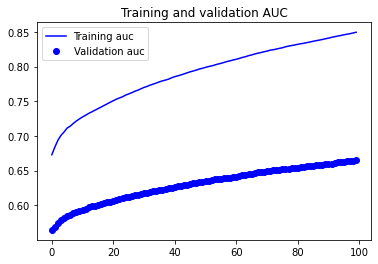

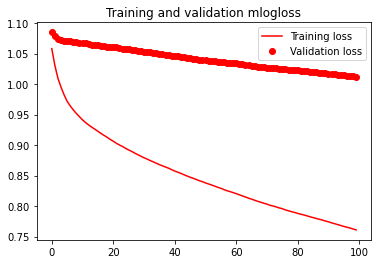

In [43]:
auc = evals_result['train']['auc']
val_auc = evals_result['validation']['auc']
loss = evals_result['train']['mlogloss']
val_loss = evals_result['validation']['mlogloss']

plt.plot(auc, 'b', label='Training auc')
plt.plot(val_auc, 'bo', label='Validation auc')
plt.title('Training and validation AUC')
plt.legend()

plt.figure()

plt.plot(loss, 'r', label='Training loss')
plt.plot(val_loss, 'ro', label='Validation loss')
plt.title('Training and validation mlogloss')
plt.legend()

plt.show()

## Conclusion
<br>
Out of the four baseline models, support vector classifiers (SVC) performed the best with the GPU accelerated version performing slightly better than Sklearns by only a few decimels. GridSearch over Sklearns SVC took approx. 9 hours to complete whereas cuMLs version only took 1 hour. The difference in performance can not be recognized as a result of differing parameters, as both instances of GridSearch deemed "C: 100", "gamma: 0.001" and "kernel: rbf" to be the best fit for our dataset.  

The logistic regression model performed the worst only generating a weighted F1 score of about 0.42 and an accuracy of 0.43. This can be a result of our fairly unbalanced dataset. We attempted to solve the problem via oversampling and splitting the original train and augmenting that data however it did not seem to help in regards to logistic regression. Further, we saw something similar with XGBoost, where that model performed above logistic regressions ability but still failed to generalize properly towards unseen data during validation. You can see this visually by viewing the plot above comparing the AUC, and loss between both train and test sets. XGBoost might have performed decently if the number of rounds were increased substantially however, due to time constraints and computing  limitations this is not feasible at the moment. 

Overall these 3 distinct algorithims provided us with a benchmark level of performance for our next phase, extended modeling where will utilize deep learning through the use of convlutional neural networks. 